In [186]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import astropy.units as u
from os import path

In [2]:
prefix = '1to13'
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec1to13/'
log_path = path + 'log/'

In [3]:
df = pd.read_csv(prefix + '_filt_flare_out.csv')
df_param = pd.read_csv(prefix + '_filt_param_out.csv')
len(df)

7495

In [317]:
# Measure flare energies from GAIA data
tic_gaia_table = pd.read_csv('ticGAIA1to13.csv')
df_g = pd.merge(tic_gaia_table, df, on='TIC', how='inner')
df_g = df_g.dropna(subset=['lum'])
ed = (df_g['ed'].values*u.day).to(u.s)
ed_err = (df_g['ed_err'].values*u.day).to(u.s)
energy = (ed*df_g['lum']*u.erg/u.s).value
energy_err = (ed_err*df_g['lum']*u.erg/u.s).value
df_g['energy'] = energy
df_g['energy_err'] = energy_err
print(len(df), len(df_g))

7495 5747


In [318]:
# One extra piece of information I need:
# How many days was each target observed by TESS?

# This is really slow, save the results to a file
if not path.exists('num_obs.txt'):
    # To start, get all of the TICs with a flare detection
    flare_tics = df_g['TIC'].values.astype(int)

    # For each TIC, determine how many files are associated with it
    num_obs = np.zeros_like(flare_tics)
    # We can search all lines at once in the text file with pandas
    files = pd.read_csv('1to13_files.txt', header=None)

    for idx, TIC in enumerate(flare_tics):
        num_obs[idx] = len(np.where(files[0].str.contains(str(flare_tics[idx]).zfill(16)) == True)[0])

    np.savetxt('num_obs.txt', (flare_tics, num_obs))
    
else:
    flare_tics, num_obs = np.loadtxt('num_obs.txt')

/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


array([-1.93868446, 69.0952691 ])

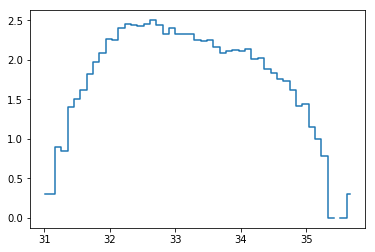

In [319]:
en = df_g['energy']
logbins = np.logspace(np.log10(np.min(en)), np.log10(np.max(en)))
hist, bins = np.histogram(en, bins=logbins)
bins = 0.5*(bins[1:] + bins [:-1])
logx, logy = np.log10(bins), np.log10(hist)
plt.plot(logx, logy, linestyle='steps-mid')

# We are way incomplete below 1e34 ergs, need big error bars to account for this
mask = np.isfinite(logy) & (bins > 5e34)
np.polyfit(logx[mask], logy[mask], 1)

In [261]:
# Improved poisson error
def Perror(n):
    err_down = n * (1. - 1. / (9. * n) -1./(3. * np.sqrt(n)))**3 - n
    err_up = n + np.sqrt(n + 0.75) + 1.0 - n 
    return err_down, err_up

-1.109758554922098 +/- 0.009275177837059213
-1.053834964160876 +/- 0.009336486411548087
-0.905223068549369 +/- 0.020633368419392766
-1.2214315961932813 +/- 0.06396448924540357
-1.498062216465758 +/- 0.33243950160642644
-1.027602303585331 +/- 0.0691420925969276
-1.071370894532597 +/- 0.05602993249255835
-0.5820745187537297 +/- 0.008035176853477387
-1.8699577477420875 +/- 0.12662060769402916
-1.029104883148755 +/- 0.07409017133448778
-1.1403942555752107 +/- 0.08901479177613872
-1.0264464375107694 +/- 0.026820446612295115


Text(0, 0.5, 'log Cum. Flare Freq (#/day)')

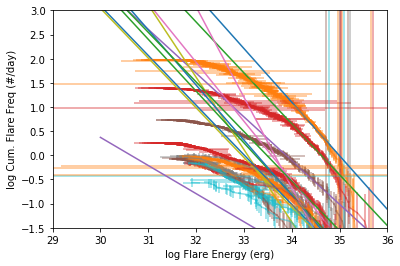

In [353]:
from scipy.odr import *

for no in np.arange(1, np.max(num_obs)):
    tess_time = 23.4*no
    
    mask_no = np.isin(df_g['TIC'], flare_tics[num_obs == no])
    e_sort = np.argsort(df_g[mask_no]['energy'].values)
    ed = (df_g['ed'][mask_no].values*u.day).to(u.s).value
    ed_err = (df_g['ed_err'][mask_no].values*u.day).to(u.s).value
    sn = ed / np.sqrt(ed + ed_err)

    x_vals = df_g['energy'][mask_no].values[e_sort]
    log_x_vals = np.log10(x_vals)
    y_vals = np.arange(0.001, len(energy[mask_no]))[::-1]/tess_time
    log_y_vals = np.log10(y_vals)
    log_x_err = 1/np.log(10)/sn[e_sort]/np.log10(ed[e_sort])
    _, perror = Perror(10**log_y_vals*tess_time)
    log_y_err = 1/np.log(10)*perror/tess_time/y_vals
    
    def f(B, x):
        if B[0] > 0:
            return np.inf
        return B[0]*x + B[1]

    b00, b10 = -0.5, 10

    mask = log_x_vals > 34

    linear = Model(f)
    mydata = Data(log_x_vals[mask], log_y_vals[mask], wd=1/log_x_err[mask]**2, we=1/log_y_err[mask]**2)
    myodr = ODR(mydata, linear, beta0=[b00, b10])
    myoutput = myodr.run()
    b0, b1 = myoutput.beta[0], myoutput.beta[1]
    b0_err, b1_err = myoutput.sd_beta[0], myoutput.sd_beta[1]

    print(str(b0) + ' +/- ' + str(b0_err))

    x_model = np.linspace(30, 37)
    y_model = b0*x_model + b1
    plt.plot(x_model, y_model)

    plt.errorbar(log_x_vals, log_y_vals, xerr=log_x_err, yerr=log_y_err, alpha=0.5)
    
plt.xlim(29, 36)
plt.ylim(-1.5, 3)
plt.xlabel('log Flare Energy (erg)')
plt.ylabel('log Cum. Flare Freq (#/day)')

array([ 0.30822569, -5.93528155])

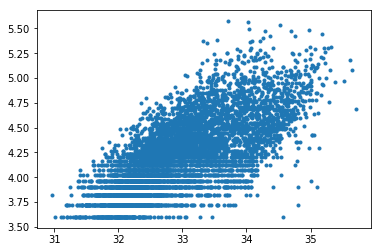

In [363]:
xvals = np.log10(df_g['energy'])
yvals = np.log10(((df_g['t1']-df_g['t0']).values*u.d).to(u.s).value)
plt.scatter(xvals, yvals, marker='.')

np.polyfit(xvals, yvals, 1)